In [1]:
from packaging import version
import sklearn
import tensorflow as tf

- 텐서플로 데이터 API는 대규모 데이터셋을 효율적으로 로드하고 전처리할 수 있도록 한다.
- 텐서플로가 멀티스레딩, 큐, 배치, 프리페치 같은 상세한 사항을 모두 대신 처리해준다.
- 또한 데이터 API는 tf.keras와도 잘 동작한다.

이 장에서는 데이터 API, TFRecord 포맷을 다루고 사용자 정의 전처리 층을 만드는 방법과 표준 케라스 전처리 층을 사용하는 법을 다룬다.

# 1. 데이터 API
- from_tensor_slices() 함수는 텐서를 받아 X의 각 원소가 아이템으로 표현되는 tf.data.Dataset을 만든다.<br>
    - 즉 데이터셋은 0,1,2,,9에 해당하는 10개의 아이템을 가진다.

In [2]:
X = tf.range(10) # 데이터 텐서
dataset = tf.data.Dataset.from_tensor_slices(X) # 메모리 전체에서 데이터셋 생성
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [3]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [4]:
# make dict
X_neated = {"a": ([1,2,3],[4,5,6]), "b":[7,8,9]}
dataset = tf.data.Dataset.from_tensor_slices(X_neated)
for item in dataset:
    print(item)

{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=4>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=7>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=5>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=8>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=6>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=9>}


## 1. 연쇄변환
데이터셋이 준비되면 변환 메서드를 호출하여 여러 종류의 변환을 수행할 수 있다.
- repeat(x) 메서드: 반복횟수. 원본 데이터셋의 아이템을 x차례 반복하는 새로운 데이터셋 반환
- batch(x) 메서드: 배치크기

In [5]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7)
dataset_dr = dataset.repeat(3).batch(7, drop_remainder=True) # drop_remainder=True로 하면 남은 [8 9]는 drop
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


map으로 데이터 변환<br>
- num_parallel_calls 매개변수로 여러 스레드로 나누어 속도를 높일 수 있음.
- map() 메서드에 전달하는 함수는 텐서플로 함수로 변환 가능해야 함.

In [6]:
# 각 아이템에 *2 해주기
dataset = dataset.map(lambda x:x * 2) # x는 배치
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


2023-08-08 14:11:25.458259: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [7]:
# reduce_sum : 텐서의 모든 성분의 총합을 계산하는 함수
dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 50)
for item in dataset:
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)


In [8]:
# 위의 dataset 중에서 2개만 보고싶을 때
for item in dataset.take(2):
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)


## 2. Shuffling the data
경사 하강법은 훈련셋에 있는 샘플이 독립적이고 동일한 분포일 때 최고 성능을 발휘한다. shuffle() 메서드로 간단하게 샘플을 섞어 데이터 분포를 적절하게 만들 수 있다.<br>
- shuffle() 메서드<br>
  [동작순서]<br>
    1. 먼저 원본 데이터셋의 처음 아이템은 buffer_size 개수만큼 추출하여 버퍼에 채운다.
    2. 그다음 새로운 아이템이 요청되면 이 버퍼에서 비워진 버퍼를 채운다.
    3. 원본 데이터셋의 모든 아이템이 사용될 때까지 반복된다.
    4. 그다음엔 버퍼가 비워질 때까지 계속라여 랜덤하게 아이쳄을 반환한다.
  - 이 메서드를 사용하려면 버퍼 크기를 지정해야 한다. 메모리를 넘지 않는 선에서 버퍼 크기를 충분히 크게 하는 것이 중요하다.<br>
 
⬇︎ 정수 0에서 9까지 세 번 반복된 데이터셋을 만든 다음, 버퍼 크기 4, 랜덤 시드 42를 사용하여 셔플링하고, 배치 크기 7로 나누어 출력

In [9]:
dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([1 4 2 3 5 0 6], shape=(7,), dtype=int64)
tf.Tensor([9 8 2 0 3 1 4], shape=(7,), dtype=int64)
tf.Tensor([5 7 9 6 7 8], shape=(6,), dtype=int64)


❗️셔플된 데이터셋이 repeat() 메서드를 호출하면 기본적으로 반복마다 새로운 순서를 생성한다.<br> 하지만 반복마다 동일한 순서를 사용해야 한다면 repeat() 메서드에 reshuffle_each_iteration=False를 지정해야 한다.
### 여러 파일에서 한 줄씩 번갈아 읽기
⬇︎ california_housing dataset 실습

In [10]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [11]:
# 데이터셋을 20개 파일로 분할하여 csv로 저장
import numpy as np
from pathlib import Path

def save_to_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = Path() / "datasets" / "housing"
    housing_dir.mkdir(parents=True, exist_ok=True)
    filename_format = "my_{}_{:02d}.csv"

    filepaths = []
    m = len(data)
    chunks = np.array_split(np.arange(m), n_parts)
    for file_idx, row_indices in enumerate(chunks):
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        filepaths.append(str(part_csv))
        with open(part_csv, "w") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ','.join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)

In [12]:
# 위의 csv 파일 중 하나의 처음 몇 줄 살펴보기
print("".join(open(train_filepaths[0]).readlines()[:10]))

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621
7.1736,12.0,6.289002557544757,0.9974424552429667,1054.0,2.6956521739130435,33.55,-117.7,2.621
2.0549,13.0,5.312457454050374,1.0850918992511913,3297.0,2.2443839346494214,33.93,-116.93,0.956
2.9583,50.0,5.380281690140845,1.1173708920187793,579.0,2.7183098591549295,33.98,-118.06,1.726
3.52,23.0,4.698216735253772,1.0342935528120714,2202.0,3.0205761316872426,34.14,-118.01,1.873
2.7188,32.0,5.511627906976744,1.067829457364341,1337.0,2.5910852713178296,34.94,-120.42,1.337
2.6563,26.0,4.29489291598023,1.1235584843492588,1401.0,2.3080724876441514,37.68,-122.08,1.841



In [13]:
train_filepaths

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv',
 'datasets/housing/my_train_05.csv',
 'datasets/housing/my_train_06.csv',
 'datasets/housing/my_train_07.csv',
 'datasets/housing/my_train_08.csv',
 'datasets/housing/my_train_09.csv',
 'datasets/housing/my_train_10.csv',
 'datasets/housing/my_train_11.csv',
 'datasets/housing/my_train_12.csv',
 'datasets/housing/my_train_13.csv',
 'datasets/housing/my_train_14.csv',
 'datasets/housing/my_train_15.csv',
 'datasets/housing/my_train_16.csv',
 'datasets/housing/my_train_17.csv',
 'datasets/housing/my_train_18.csv',
 'datasets/housing/my_train_19.csv']

### 입력 파이프라인 구축
기본적으로 list_files() 함수는 파일 경로를 섞은 데이터셋을 반환한다. 이를 원하지 않는다면 shuffle=False로 지정하면 된다. 하지만 일반적으로 shuffle을 한다.

In [14]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [15]:
# filepath가 섞여있음을 보여줌
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets/housing/my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_17.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_13.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_15.csv', shape=(), dtype=string)
tf.Ten

In [16]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1), # skip(1): 열 이름은 스킵
    cycle_length=n_readers)

interleave() 메서드는 filepath_dataset에 있는 다섯 개의 파일 경로에서 데이터를 읽는 데이터셋을 만든다.<br>
이 메서드에 전달한 lambda 함수는 각 파일에 대해 호출하여 새로운 데이터셋(위의 경우 TextLineDataset)을 만들 것이다.

list

In [17]:
# 데이터 확인
for line in dataset.take(5):
    print(line.numpy())

b'4.5909,16.0,5.475877192982456,1.0964912280701755,1357.0,2.9758771929824563,33.63,-117.71,2.418'
b'2.4792,24.0,3.4547038327526134,1.1341463414634145,2251.0,3.921602787456446,34.18,-118.38,2.0'
b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67'
b'2.1856,41.0,3.7189873417721517,1.0658227848101265,803.0,2.0329113924050635,32.76,-117.12,1.205'
b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215'


## 3. 전처리

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [19]:
X_mean, X_std = scaler.mean_, scaler.scale_
n_inputs = 8

# csv한 라인을 받아 파싱
def parse_csv_line(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs) # io.decode_csv() 함수로 파싱: 열마다 한 개씩 스칼라 텐서의 리스트를 반환
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])

# 
def preprocess(line):
    x, y, = parse_csv_line(line)
    return (x - X_mean) / X_std, y # 스케일 조정

In [20]:
preprocess(b'2.1856,41.0,3.7189873417721517,1.0658227848101265,803.0,2.0329113924050635,32.76,-117.12,1.205')[0]

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-0.8936168 ,  0.9789995 , -0.6810549 , -0.07264194, -0.5669866 ,
       -0.39212456, -1.3522334 ,  1.2316071 ], dtype=float32)>

## 4. 데이터 적재와 전처리를 합치기
마지막 라인의 **prefetch(1)** 는 성능에 아주 중요한 역할을 한다.
- prefetch(1)을 호출하면 훈련 알고리즘이 한 배치로 작업을 하는 동안 이 데이터셋이 다름 배치를 준비한다.
- interleave()와 map() 메서드를 호출할 때 num_parallel_calls 매개변수를 지정하여 멀티스레드로 데이터를 적재하고 전처리하면 CPU의 멀티 코어를 활용하여 매우 빠른 시간 안에 한 배치 데이터를 준비할 수 있다.
- 위와 같은 방법으로 GPU를 100% 활용할 수 있다. 결국 prefetch로 CPU와 GPU를 동시에 사용한다. GPU가 한 배치를 처리할 때 CPU가 그다음 배치를 준비한다.

⬇︎ 데이터셋을 효율적으로 적재, 전처리, 셔플링, 반복, 배치를 적용한 데이터셋 만들어 반환<br>
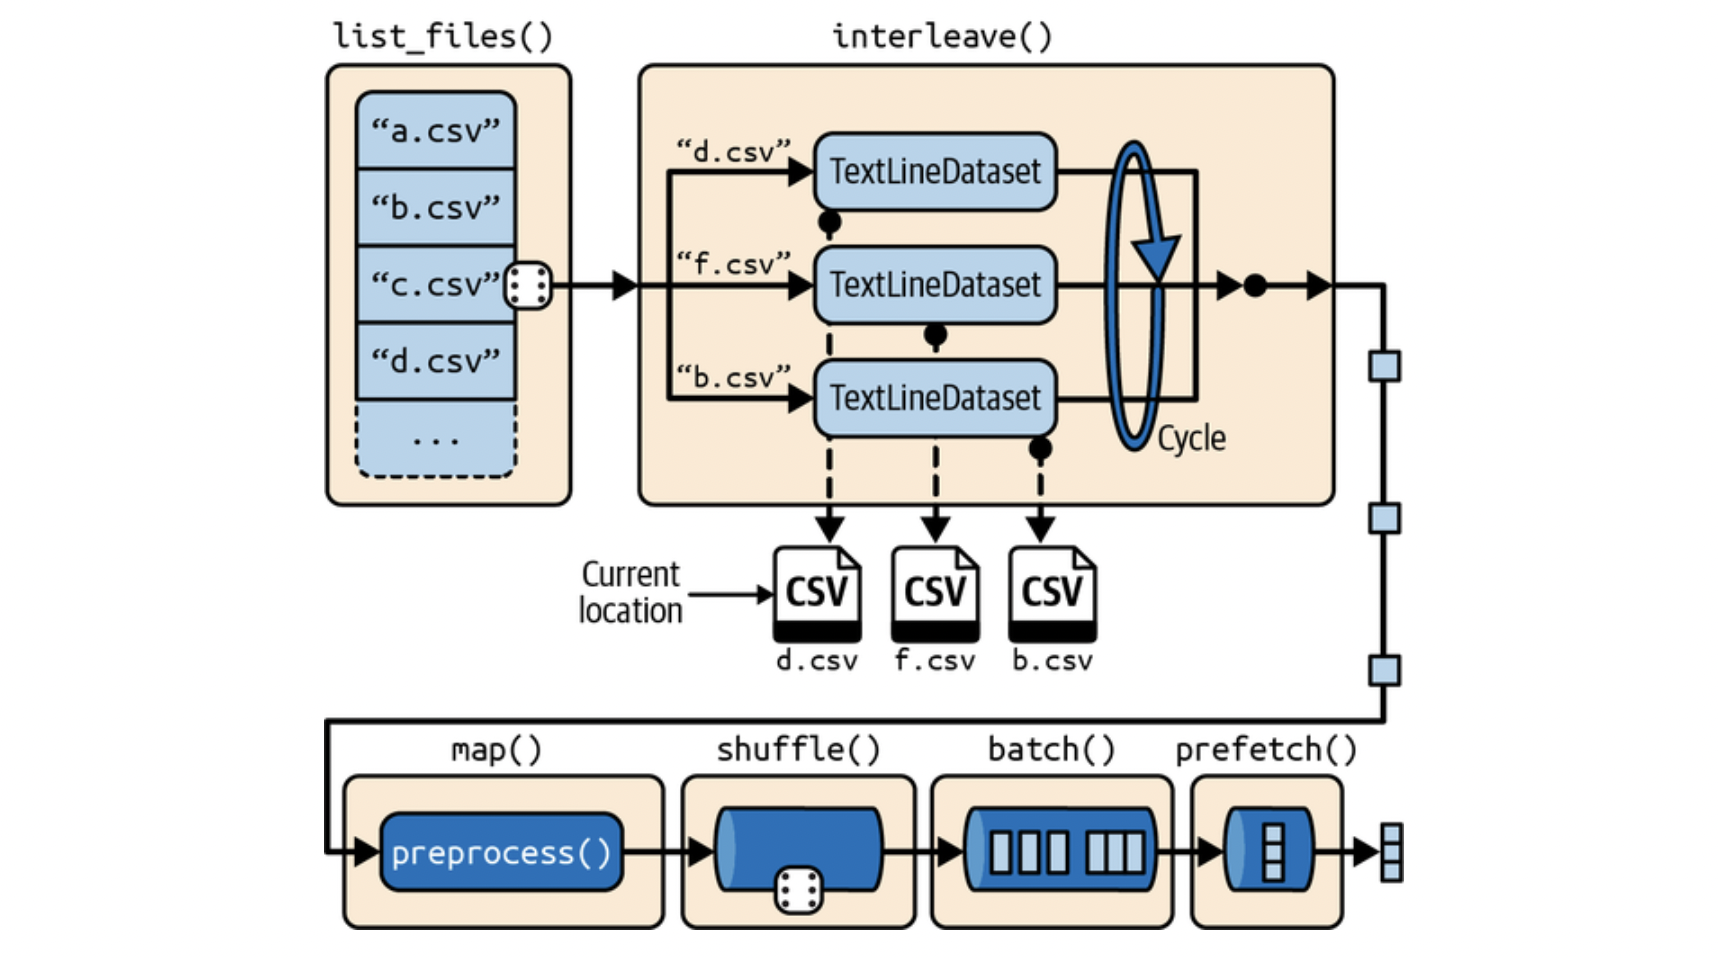

In [21]:
def csv_reader_dataset(filepaths, n_readers=5, n_read_threads=None,
                      n_parse_threads=5, shuffle_buffer_size=10_000, seed=42,
                      batch_size=32):
    dataset = tf.data.Dataset.list_files(filepath, seed=seed)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(fielpath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    return dataset.batch(batch_size).prefetch(1)

SyntaxError: incomplete input (3655879008.py, line 4)

In [22]:
file_paths

NameError: name 'file_paths' is not defined

In [23]:
pwd

'/Users/biny/Desktop/git/Hands-On-ML/혜빈'